In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import os, sys, gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
DATA_DIR = f"../input/colombiacareerrecommender"
os.listdir("../input/colombiacareerrecommender")

['Saber_Data_with_Null_Percentage.csv',
 'saber_combined_preprocessed.csv',
 'translate_headers.txt',
 'README.md',
 'Colombia_departamentos_municipios_poblacion-topo.json',
 'translate_cat.txt',
 'database.json',
 'spanish_to_english.txt']

In [3]:
df = pd.read_csv(f"{DATA_DIR}/saber_combined_preprocessed.csv")
df.shape, df.columns

((212010, 98),
 Index(['your_type_of_document', 'your_nationality', 'your_gender',
        'your_birthdate', 'your_foreigner', 'period', 'your_consecutive',
        'your_marital_status', 'your_student', 'your_country_resides',
        'your_have_ethnicity', 'your_dept_resides', 'your_dept_code_resides',
        'your_municipality_resides', 'your_municipality_code_resides',
        'your_high_school_degree', 'your_tuition_cost_university',
        'your_tuition_pymt_scholarship', 'your_tuition_pymt_credit',
        'your_tuition_pymt_parents', 'your_tuition_pymt_yourself',
        'fami_current_household_type', 'fami_is_the_head_family',
        'fami_econ_dependents', 'fami_father_education',
        'fami_mother_education', 'fami_father_occupation',
        'fami_mother_occupation', 'fami_housing_stratum', 'fami_internet',
        'fami_computer', 'fami_automobile', 'fami_num_books',
        'inst_institution_code', 'inst_institution_name', 'your_prgm_academic',
        'group_refere

In [4]:
df.isna().sum().sum()

0

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import scipy.sparse as scipy_sparse
from scipy.sparse.linalg import svds
import plotly.express as px
import plotly.graph_objs as go
from sklearn import preprocessing

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
df = reduce_mem_usage(df)

Memory usage after optimization is: 130.41 MB
Decreased by 17.7%


In [7]:
replace_dict = {'AGRICULTURAL, FORESTRY ENGINEERING':'AGRICULTURAL, FOREST ENGINEERING',
               'AGROINDUSTRIAL ENGINEERING, FOOD':'AGROINDUSTRIAL AND FOOD ENGINEERING',
               'TRAINING RELATED TO THE MILITARY OR POLICE FIELD':'MILITARY OR POLICE TRAINING',
               'NUTRITION AND DIET':'NUTRITION AND DIETETICS'}
df['your_undergraduate_core'] = df['your_undergraduate_core'].replace(replace_dict)

In [8]:
df = df[df['your_undergraduate_core'] != 'UNCLASSIFIED']
df = df[df['your_undergraduate_core'] != 'UNKNOWN']
df['your_undergraduate_core'].value_counts()

ADMINISTRATION                                  35790
LAW                                             15263
PUBLIC ACCOUNTING                               14334
EDUCATION                                       14219
INDUSTRIAL ENGINEERING                          10660
PSYCHOLOGY                                      10518
ENVIRONMENTAL, SANITARY ENGINEERING              8231
CIVIL ENGINEERING                                7736
SOCIAL COMMUNICATION, JOURNALISM                 7479
ECONOMY                                          7243
COMPUTER SYSTEMS, TELEMATICS ENGINEERING         6805
MECHANICAL ENGINEERING                           5382
DESIGN                                           5263
ARCHITECTURE                                     3969
SOCIOLOGY, SOCIAL WORK                           3832
NURSING                                          3440
ELECTRONIC ENGINEERING, TELECOMMUNICATIONS       2845
MEDICINE                                         2764
SUPERIOR NORMALS            

In [9]:
score_cols = ['score_language_saber_11','score_mathematics_saber_11',
              'score_biology_saber_11','score_chemistry_saber_11', 
              'score_physics_saber_11','score_social_science_saber_11',
              'score_philosophy_saber_11','score_english_saber_11',
              'score_optative_saber_11','score_math_saber_pro', 'score_language_saber_pro',
              'score_social_science_saber_pro', 'score_english_saber_pro',
              'score_writing_saber_pro']

In [10]:
mdf = pd.melt(df[score_cols], var_name=['Subject'])
mdf.columns

Index(['Subject', 'value'], dtype='object')

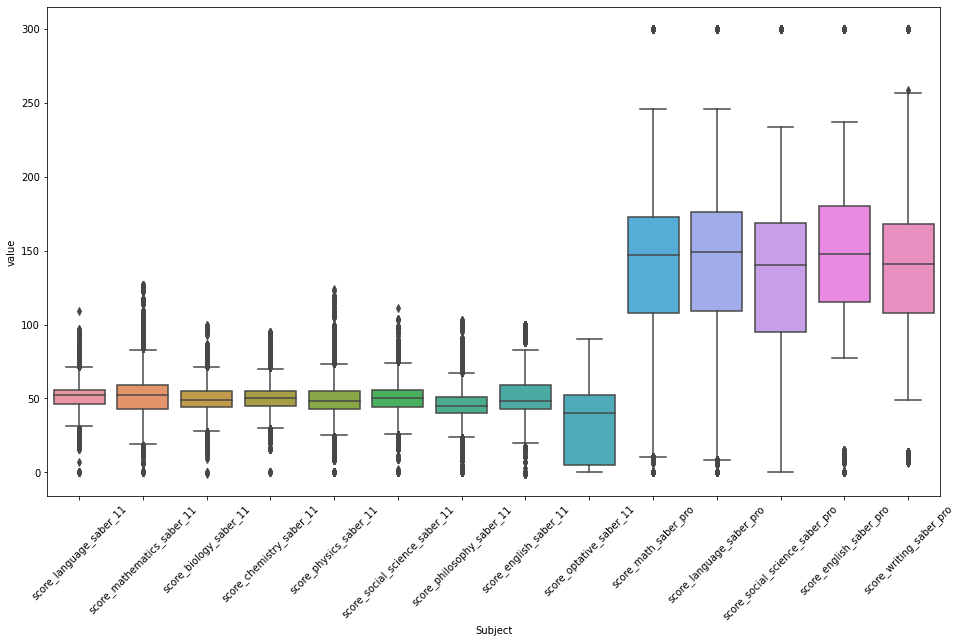

In [11]:
import seaborn as sns

plt.figure(figsize=(16,9))
# create plot
ax = sns.boxplot(x="Subject", y="value", data=mdf)
plt.xticks(rotation=45)
# show plot
plt.show()

In [12]:
# normalize the different eng majors
ENGINEERING_dict = {"INDUSTRIAL ENGINEERING":'ENGINEERING',
"ENVIRONMENTAL, SANITARY ENGINEERING":'ENGINEERING',
"CIVIL ENGINEERING":'ENGINEERING',
"COMPUTER SYSTEMS, TELEMATICS ENGINEERING":'ENGINEERING',
"MECHANICAL ENGINEERING":'ENGINEERING',
"ELECTRONIC ENGINEERING, TELECOMMUNICATIONS":'ENGINEERING',
"CHEMICAL ENGINEERING":'ENGINEERING',
"MINING, METALLURGY ENGINEERING":'ENGINEERING',
"OTHER ENGINEERING":'ENGINEERING',
"ELECTRICAL ENGINEERING":'ENGINEERING',
"AGROINDUSTRIAL AND FOOD ENGINEERING":'ENGINEERING',
"AGRONOMIC, LIVESTOCK ENGINEERING":'ENGINEERING',
"ADMINISTRATIVE ENGINEERING":'ENGINEERING',
"BIOMEDICAL ENGINEERING":'ENGINEERING',
"AGRICULTURAL, FOREST ENGINEERING":'ENGINEERING',
}

In [13]:
# Gender
source = df.groupby('your_gender').count()[['your_consecutive']].reset_index().rename(columns={'your_consecutive':'obs'})
source

,your_gender,obs
0,F,125290
1,M,78106


In [14]:
# Marital Status
source = df.groupby('your_marital_status').count()[['your_consecutive']].reset_index().rename(columns={'your_consecutive':'obs'})
source

,your_marital_status,obs
0,Free Union,3675
1,Married,1645
2,Separated and/or Divorced,66
3,Separated and/or Widowed,145
4,Single,197852
5,Widowed,13
